In [1]:
import torch
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Tanh
from torch.nn import Sigmoid
from torch.nn import Module
from torch.nn import Embedding 
from torch.optim import SGD,Adam
from torch.nn import CrossEntropyLoss, BCELoss, MSELoss
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error
import numpy as np
from numpy import vstack
from sklearn.decomposition import PCA
from torch.utils.data import random_split
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
import matplotlib
import seaborn as sb
import math
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
# model definition
class RNN(Module):
    # define model elements
    # n_inputs: input dimension
    # n_hidden: number of neurons per layer
    # n_layers: number of hidden layers
    def __init__(self, n_hidden, n_layers, input_dim):
        super(RNN, self).__init__()
        
        # hidden layers
        #self.embed = Embedding(input_dim, embedding_dim) 
        self.hidden = {}
        self.act = {}
        for i in range(n_layers):
            if i==0:
                n_in = input_dim + n_hidden # embedding_dim + n_hidden
            else:
                n_in = n_hidden * 2
            # input to hidden layer
            self.hidden[i] = Linear(n_in, n_hidden)
            kaiming_uniform_(self.hidden[i].weight, nonlinearity='relu')
            # non-linearity
            self.act[i] = ReLU()
        
        # output
        self.out = Linear(n_hidden,1) # dimension of output is 2
        xavier_uniform_(self.out.weight)
        self.actout = Sigmoid()
        
        
    # forward propagate input
    def forward(self, X, hidden_layer):
        n_layers = len(hidden_layer)
        #idx = torch.argmax(X,-1)
        #embedding = self.embed(idx)
        for i in range(n_layers):
            if i == 0:
                # combine input with previous hidden
                combined = torch.cat((X, hidden_layer[i]), 1)
            else:
                # combine previous hidden with hidden
                combined = torch.cat((hidden_layer[i-1], hidden_layer[i]), 1)
            # input to hidden layer
            hidden_layer[i] = self.hidden[i](combined)
            hidden_layer[i] = self.act[i](hidden_layer[i])
            
        ## output
        output = self.out(hidden_layer[i])
        output = self.actout(output) # same/different classification
        #output = self.actout(output)

        return output,hidden_layer

In [3]:
# train the model
def train_model(train_x, val_x,model):
    n_layers = len(model.hidden)
    n_hidden = model.hidden[0].weight.size()[0]
    # define the optimization
    criterion = BCELoss()
    optimizer = Adam(model.parameters(), lr=0.01)
    
    batch_size = train_x.shape[0]
    n_timepoints = train_x.shape[1]
    
    all_loss = []
    lossdiff = -1
    epoch = 0
    while lossdiff<0:
       
        # initialise hidden states
        hi = {}
        hiv = {}
        for k in range(n_layers):
            hi[k] = torch.zeros((batch_size,n_hidden))
            hiv[k] = torch.zeros((batch_size,n_hidden))
        l = []
        lv = []
        for i in range(n_timepoints):# items in sequence
            x = train_x[:,i,:]
                
            # compute the model output
            yhat,hi = model(x,hi)
                
            # validation
            xv = val_x[:,i,:]
            yval,hiv = model(xv,hiv)
            if i>0:
                change = np.round(torch.mean((x!=train_x[:,i-1,:]).float(),-1))# compute change variable
                change_val = np.round(torch.mean((xv!=val_x[:,i-1,:]).float(),-1))# compute change variable
                optimizer.zero_grad()
                loss = criterion(yhat[:,0],change)
                loss_val = criterion(yval[:,0],change_val)
                
                loss.backward(retain_graph=True)
                optimizer.step()
       
        
        all_loss.append(loss_val.item())  
        if epoch>10:
            lossdiff = all_loss[-1]-np.mean(all_loss[-10:-1] )
        if epoch>1000:
            lossdiff = 1 # break
        epoch +=1
    return all_loss


def predict(x,model):
    
    n_layers = len(model.hidden)
    n_hidden = model.hidden[0].weight.size()[0]

    
    
    batch_size = x.size()[0]
    h = {}
    for k in range(n_layers):
        h[k] = torch.zeros((batch_size,n_hidden))
    Yhat,H = np.zeros((batch_size,x.size()[1])), np.zeros((batch_size,x.size()[1], n_hidden))
    for j in range(x.size()[1]):
        xj = x[:,j,:]
        # compute the model output
        yhat,h = model(xj,h)
        
        Yhat[:,j] = yhat[:,0].detach().numpy() # predicted stimulus
        H[:,j,:] = h[1].detach().numpy()
   
    return Yhat,H #,c


Create input sequences

In [4]:
def make_sequence(seq,repeats,pairs,zero_vector,deviance_prob):
    
    '''
    Create a structured sequence such as 010101, replacing 0 and 1 with (one-hot) vectors from dictionary
    
    batch_size: number of sequence samples with different value for 0 and 1
    seq: list of sequence structures
    repeats: repeats per sequence chunk (e.g. 4 = 4xsize of sequence chunk)
    dictionary: matrix of (one-hot) vectors, shape: dic size X input size
    zero_vector: vector to be used for the zero state
    deviance_prob: probability of global deviant
    '''
    nseq = len(seq)
    x = np.zeros((nseq))
    input_size = pairs.shape[2]
    batch_size = pairs.shape[0]
    all_seq = []
    seq_len = []
    for s in seq:
        
        # pick value from dictionary:
        a = []
        b = []
        for i in range(batch_size):
            a.append(pairs[i,0,:]) # X
            b.append(pairs[i,1,:]) # Y
        a = np.array(a)
        b = np.array(b)
        # create sequence
        sequence = []
        for i,element in enumerate(s):
            if element==0:
                sequence.append(a)
            elif element==1:
                sequence.append(b)

        sequence = np.array(sequence)
         
        sequence = np.swapaxes(sequence,0,1)
        # add zero state
        sequence = np.concatenate((sequence,np.repeat(zero_vector[None,:,:],batch_size,0)),1)
        out_sequence = sequence
        #global_deviants = np.round(np.random.rand(repeats-2)-(0.5-deviance_prob))
        for r in range(repeats-1):
            # stack the sequence repeat times
            out_sequence = np.concatenate((out_sequence,sequence),1)
            # insert global deviant according to global_Deviants for all chunks but last
            #if r<repeats-2:
            #    if global_deviants[r]==1:
            #        # check wich item is the last
            #        if np.mean(out_sequence[:,-2]==a):
            #            out_sequence[:,-2]=b #switch
            #        else:
            #            out_sequence[:,-2]=a
            #    
        all_seq.append(out_sequence)

    return all_seq


### Training & Testing on structure switch

In [5]:
input_size = 2 # dimensionality of the input
batch_size = 200 # size of stimulus dictionary
n_hidden = 128
n_layers = 2
deviance_prob = 0
N = 100 # number of samples
change_probability = 0.5
binsize = 22.5
bins = np.arange(-180,180,binsize)

In [6]:
x_train = np.zeros((batch_size,N,2))
x_test = np.zeros((batch_size,N,2))
x_oddball = np.zeros((batch_size,N,2))
x_val = np.zeros((batch_size,N,2))
y = np.zeros((batch_size,N))
y_test = np.zeros((batch_size,N))
y_val = np.zeros((batch_size,N))
y_oddball = np.zeros((batch_size,N))
values = (bins+180)/360
for i in range(N):
    # training data
    alpha_new = np.random.choice(values,batch_size)
    change = np.random.rand(batch_size)+(change_probability-0.5)
    if i>0:
        alpha[np.round(change)==1] = alpha_new[np.round(change)==1]
    else:
        alpha = alpha_new
    z = np.exp(2*np.pi*1j*alpha)
    a = z.real
    b = z.imag
    x_train[:,i,0],x_train[:,i,1] = a,b
    y[:,i] = np.round(change)
    
    # test data
    alpha_new = np.random.choice(values,batch_size)
    change = np.random.rand(batch_size)+(change_probability-0.5)
    if i>0:
        alpha_test[np.round(change)==1] = alpha_new[np.round(change)==1]
    else:
        alpha_test = alpha_new
    z = np.exp(2*np.pi*1j*alpha_test)
    a = z.real
    b = z.imag
    x_test[:,i,0],x_test[:,i,1] = a,b
    y_test[:,i] = np.round(change)

    # validation data
    alpha_new = np.random.choice(values,batch_size)
    change = np.random.rand(batch_size)+(change_probability-0.5)
    if i>0:
        alpha_val[np.round(change)==1] = alpha_new[np.round(change)==1]
    else:
        alpha_val = alpha_new
    z = np.exp(2*np.pi*1j*alpha_val)
    a = z.real
    b = z.imag
    x_val[:,i,0],x_val[:,i,1] = a,b
    y_val[:,i] = np.round(change)

    
    # oddball data
    change = np.random.rand(batch_size)+(0.05-0.5)
    if i>0:
        alpha_oddball[np.round(change)==1] = alpha_oddball[np.round(change)==1]+1/4
    else:
        alpha_oddball = np.random.choice(values,batch_size)
    z = np.exp(2*np.pi*1j*alpha_oddball)
    a = z.real
    b = z.imag
    x_oddball[:,i,0],x_oddball[:,i,1] = a,b
    y_oddball[:,i] = np.round(change)

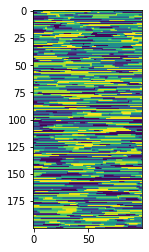

In [7]:
plt.imshow(x_oddball[:,:,0])

In [ ]:

print('%s units per layer, %s layer, %s input dimensions'%(n_hidden,n_layers, input_size))


# train network
model = RNN(n_hidden,n_layers,input_size)
Loss = train_model(torch.Tensor(x_train),torch.Tensor(x_val),model)
plt.plot(Loss)
plt.show()

# evaluation
Yhat,H = predict(torch.Tensor(x_test),model)
# evaluation on oddball
Yoddball,Hoddball = predict(torch.Tensor(x_oddball),model)

Acc = np.mean(np.round(Yhat)==y_test)
Acc_oddball = np.mean(np.round(Yoddball)==y_oddball)
print(Acc)
print(Acc_oddball)

128 units per layer, 2 layer, 2 input dimensions


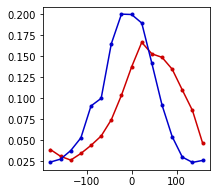

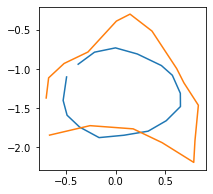

In [246]:

# get TUNING from many-standard-control
# and oddball, centred on preferred in many-standard control
angles = np.zeros((batch_size,N)) # xy to angle
angles_oddball = np.zeros((batch_size,N)) 
for i in range(batch_size):
    for j in range(N):
        angles[i,j] = math.degrees(math.atan2(x_test[i,j,1], x_test[i,j,0]))
        angles_oddball[i,j] = math.degrees(math.atan2(x_oddball[i,j,1], x_oddball[i,j,0]))
angles[angles==180] = -180
angles = np.round(np.reshape(angles,(batch_size*N)),1)
angles_oddball[angles_oddball==180] = -180
angles_oddball = np.round(np.reshape(angles_oddball,(batch_size*N)),1)

H_flat = np.reshape(H,(batch_size*N,n_hidden))
Hoddball_flat = np.reshape(Hoddball,(batch_size*N,n_hidden))

# reduce oddball to deviants and standards
angles_stnd = angles_oddball[np.reshape(y_oddball,(batch_size*N))==0]
Hstnd_flat = Hoddball_flat[np.reshape(y_oddball,(batch_size*N))==0,:]
angles_oddball = angles_oddball[np.reshape(y_oddball,(batch_size*N))==1]
Hoddball_flat = Hoddball_flat[np.reshape(y_oddball,(batch_size*N))==1,:]


# bin responses
responses_binned = np.zeros((len(bins),n_hidden))
responses_oddball_binned = np.zeros((len(bins),n_hidden))
responses_stnd_binned = np.zeros((len(bins),n_hidden))
for i,b in enumerate(bins):
    responses_binned[i,:] = np.mean(H_flat[(angles>=b) & (angles<bins[i]+binsize),:],0)
    responses_oddball_binned[i,:] = np.mean(Hoddball_flat[(angles_oddball>=b) & (angles_oddball<bins[i]+binsize),:],0)
    responses_stnd_binned[i,:] = np.mean(Hstnd_flat[(angles_stnd>=b) & (angles_stnd<bins[i]+binsize),:],0)
    
# get preferred in msc
stimpref = np.argmax(responses_binned,0)

# distance from preferred
stim_distance = np.round(np.array([bins-bins[stimpref[i]] for i in range(n_hidden)]),1)
stim_distance[stim_distance>=180] -= 360
stim_distance[stim_distance<-180] += 360

TC = np.zeros((n_hidden,len(bins)))
TCoddball = np.zeros((n_hidden,len(bins)))
TCstnd = np.zeros((n_hidden,len(bins)))
for n in range(n_hidden):
    for i in range(len(bins)):        
        TC[n,i] = np.mean(responses_binned[stim_distance[n,:]==bins[i],n])
        TCoddball[n,i] = np.mean(responses_oddball_binned[stim_distance[n,:]==bins[i],n])
        TCstnd[n,i] = np.mean(responses_stnd_binned[stim_distance[n,:]==bins[i],n])

incUnits = np.where((np.mean(TC,1)!=0) & (TC[:,int(len(bins)/2)-1]>TC[:,0]) & (TC[:,int(len(bins)/2)+1]>TC[:,-1]))[0]
fig,ax = plt.subplots(1,1,figsize=(3,3))
#plt.plot(bins,np.median(TC[incUnits,:],0),'.-',color=(0.2,0,0.2),label='Control')
plt.plot(bins,np.median(TCoddball[incUnits,:],0),'.-',color=(0.8,0,0),label='Deviant')
plt.plot(bins,np.median(TCstnd[incUnits,:],0),'.-',color=(0,0,0.8),label='Standard')
plt.show()

# regression
S = np.eye(len(bins))
Beta = responses_binned.T@S
# PCA
pca = PCA(n_components=2)
pca.fit(Beta.T)
comp = pca.components_
# project single trials onto axes
responses_pc = H_flat@comp.T
responses_oddball_pc = Hoddball_flat@comp.T
responses_binned_pc = np.zeros((len(bins),2))
responses_oddball_binned_pc = np.zeros((len(bins),2))
fig,ax = plt.subplots(1,1,figsize=(3,3))
for i,b in enumerate(bins):
    responses_binned_pc[i,:] = np.mean(responses_pc[(angles>=b) & (angles<bins[i]+binsize),:],0)
    responses_oddball_binned_pc[i,:] = np.mean(responses_oddball_pc[(angles_oddball>=b) & (angles_oddball<bins[i]+binsize),:],0)


plt.plot(responses_binned_pc[:,0],responses_binned_pc[:,1],'-')
plt.plot(responses_oddball_binned_pc[:,0],responses_oddball_binned_pc[:,1],'-')
#plt.xlim(-4,4)
#plt.ylim(-4,4)


In [238]:
TC.shape

(128, 16)

In [102]:
sum(np.isnan(responses_binned))

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

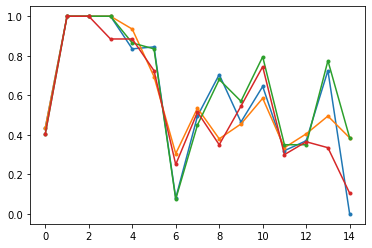

In [12]:
for i in range(len(seq_test)):
    plt.plot(np.mean(Acc[i],1),'.-')

plt.show()

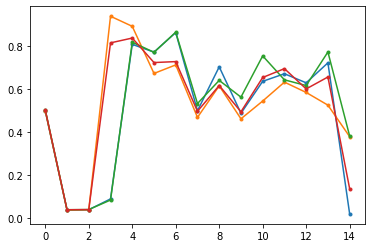

In [13]:
for i in range(len(seq_test)):
    plt.plot(np.mean(Yhat[i],0),'.-')
plt.show()

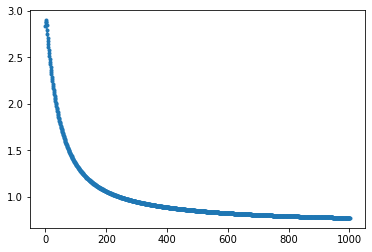

In [823]:

plt.plot(Loss,'.-')

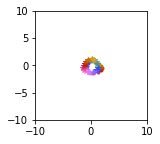

In [14]:
import math
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap
data = np.loadtxt("cyclic_colormaps/cyclic_mrybm.txt")
data2 = np.clip(data, 0, 1)
cmap = LinearSegmentedColormap.from_list('my_colormap', data2)

markers = ['.','*']
fig,ax = plt.subplots(1,1,figsize=(2,2))
for k in range(2):


    Nback = 3*len(seq_test[k]) + 3
   
    stimuli = test_sequence[k][:,-3*5+3,:]
    responses = Hidden[k][:,3,:]
    
    # centre
    #responses_dev = (responses_dev - np.repeat(np.mean(responses,0)[None,:],dict_size,0)) / (np.repeat(np.std(responses,0)[None,:],dict_size,0)+1*10e-10)
    #responses = (responses - np.repeat(np.mean(responses,0)[None,:],dict_size,0)) / (np.repeat(np.std(responses,0)[None,:],dict_size,0)+1*10e-10)

    angles = np.zeros(stimuli.shape[0])
    for i in range(stimuli.shape[0]):
        angles[i] = math.degrees(math.atan2(stimuli[i,1], stimuli[i,0]))
    # bin the angles
    binsize = 22.5
    bins = np.arange(-180,180,binsize)
    responses_binned = np.zeros((len(bins),n_hidden))
    for i,b in enumerate(bins):
        responses_binned[i,:] = np.mean(responses[(angles>=b) & (angles<bins[i]+binsize),:],0)
    #responses_binned = responses_binned - np.repeat(np.mean(responses_binned,0)[None,:],len(bins),0) / (np.repeat(np.std(responses_binned,0)[None,:],len(bins),0)+1*10e-10)
    
    # regression
    S = np.eye(len(bins))
    Beta = responses_binned.T@S
    nanind = np.where(np.isnan(np.mean(Beta,1)))[0]
    Beta[nanind,:] = 0
    # PCA
    pca = PCA(n_components=2)
    pca.fit(Beta.T)
    comp = pca.components_
    # project single trials onto axes
    responses_pc = responses@comp.T
    responses_binned = np.zeros((len(bins),2))
    for i,b in enumerate(bins):
        responses_binned[i,:] = np.mean(responses_pc[(angles>=b) & (angles<bins[i]+binsize),:],0)
        
    
    for i in range(len(bins)):
        plt.plot(responses_binned[i,0],responses_binned[i,1],marker=markers[k],color=cmap(i/len(bins)))
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
plt.show()

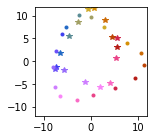

In [15]:
import math
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap
data = np.loadtxt("cyclic_colormaps/cyclic_mrybm.txt")
data2 = np.clip(data, 0, 1)
cmap = LinearSegmentedColormap.from_list('my_colormap', data2)

binsize = 22.5
bins = np.arange(-180,180,binsize)

fig,ax = plt.subplots(1,1,figsize=(2,2))
    
stimuli = test_sequence[1][:,-15+2,:]
responses = Hidden[1][:,2,:]

stimuli_dev = test_sequence[1][:,-15+3,:]
responses_dev = Hidden[1][:,3,:]

# centre
responses_dev = (responses_dev - np.repeat(np.mean(responses,0)[None,:],dict_size,0)) / (np.repeat(np.std(responses,0)[None,:],dict_size,0)+1*10e-10)
responses = (responses - np.repeat(np.mean(responses,0)[None,:],dict_size,0)) / (np.repeat(np.std(responses,0)[None,:],dict_size,0)+1*10e-10)

angles = np.zeros(stimuli.shape[0])
angles_dev = np.zeros(stimuli_dev.shape[0])
for i in range(stimuli.shape[0]):
    angles[i] = math.degrees(math.atan2(stimuli[i,1], stimuli[i,0]))
    angles_dev[i] = math.degrees(math.atan2(stimuli_dev[i,1], stimuli_dev[i,0]))


# bin the angles
responses_binned = np.zeros((len(bins),n_hidden))
responses_dev_binned = np.zeros((len(bins),n_hidden))
for i,b in enumerate(bins):
    responses_binned[i,:] = np.mean(responses[(angles>=b) & (angles<bins[i]+binsize),:],0)
    responses_dev_binned[i,:] = np.mean(responses_dev[(angles_dev>=b) & (angles_dev<bins[i]+binsize),:],0)
#responses_dev_binned = (responses_dev_binned - np.repeat(np.mean(responses_binned,0)[None,:],len(bins),0)) / (np.repeat(np.std(responses_binned,0)[None,:],len(bins),0)+1*10e-10)
#responses_binned = (responses_binned - np.repeat(np.mean(responses_binned,0)[None,:],len(bins),0)) / (np.repeat(np.std(responses_binned,0)[None,:],len(bins),0)+1*10e-10)
    
# regression
S = np.eye(len(bins))
Beta = responses_binned.T@S

# PCA
pca = PCA(n_components=2)
pca.fit(Beta.T)
comp = pca.components_

# project single trials onto axes
responses_pc = responses@comp.T
responses_pc_dev = responses_dev@comp.T
proj_responses_binned = np.zeros((len(bins),2))
proj_responses_dev_binned = np.zeros((len(bins),2))
for i,b in enumerate(bins):
    proj_responses_binned[i,:] = np.mean(responses_pc[(angles>=b) & (angles<bins[i]+binsize),:],0)
    proj_responses_dev_binned[i,:] = np.mean(responses_pc_dev[(angles_dev>=b) & (angles_dev<bins[i]+binsize),:],0)
    

for i in range(len(bins)):
    plt.plot(proj_responses_binned[i,0],proj_responses_binned[i,1],'.',color=cmap(i/len(bins)))
    plt.plot(proj_responses_dev_binned[i,0],proj_responses_dev_binned[i,1],'*',color=cmap(i/len(bins)))
ax.set_xlim(-np.max(abs(proj_responses_binned[:,0]))-0.5,np.max(abs(proj_responses_binned[:,0]))+0.5)
ax.set_ylim(-np.max(abs(proj_responses_binned[:,0]))-0.5,np.max(abs(proj_responses_binned[:,0]))+0.5)
plt.show()

## Tuning curves

In [22]:
#TC = np.zeros((n_hidden,len(bins)))
stimuli = test_sequence[0][:,-15+3,:]
stimuli_dev = test_sequence[1][:,-15+3,:]
responses = Hidden[0][:,3,:]
responses_dev = Hidden[1][:,3,:]

# centre
responses_dev = (responses_dev - np.repeat(np.mean(responses,0)[None,:],dict_size,0)) / (np.repeat(np.std(responses,0)[None,:],dict_size,0)+1*10e-10)
responses = (responses - np.repeat(np.mean(responses,0)[None,:],dict_size,0)) / (np.repeat(np.std(responses,0)[None,:],dict_size,0)+1*10e-10)

angles = np.zeros(stimuli.shape[0])
angles_dev = np.zeros(stimuli.shape[0])
for i in range(stimuli.shape[0]):
    angles[i] = math.degrees(math.atan2(stimuli[i,1], stimuli[i,0]))
    angles_dev[i] = math.degrees(math.atan2(stimuli_dev[i,1], stimuli_dev[i,0]))
    
responses_binned = np.zeros((len(bins),n_hidden))
responses_binned_dev = np.zeros((len(bins),n_hidden))
for i,b in enumerate(bins):
    responses_binned[i,:] = np.mean(responses[(angles>=b) & (angles<bins[i]+binsize),:],0)
    responses_binned_dev[i,:] = np.mean(responses_dev[(angles_dev>=b) & (angles_dev<bins[i]+binsize),:],0)

# get preferred 
stimpref_stnd = np.argmax(responses_binned,0)
stimpref_dev = np.argmax(responses_binned_dev,0)

# convert to radiant
bins_rad = bins * np.pi/180
stimpref_stnd = bins[stimpref_stnd] *np.pi/180
stimpref_dev = bins[stimpref_dev] *np.pi/180

# distance from preferred
stim_distance_stnd = np.array([np.angle(np.exp(1j*(bins_rad-stimpref_stnd[i]))) for i in range(n_hidden)])
stim_distance_stnd[stim_distance_stnd==nap.pi] = -np.pi

TCstnd = np.zeros((n_hidden,len(bins)))
TCdev = np.zeros((n_hidden,len(bins)))
for n in range(n_hidden):
    for i in range(len(bins)):

        TCstnd[n,i] = np.mean(responses_binned[np.round(stim_distance_stnd[n,:],1)==np.round(bins_rad[i],1),n])
        TCdev[n,i] = np.mean(responses_binned_dev[np.round(stim_distance_stnd[n,:],1)==np.round(bins_rad[i],1),n])
#TCdevz = (TCdev-np.repeat(np.mean(TC,1)[:,None],len(bins),1)) / (np.repeat(np.std(TC,1)[:,None],len(bins),1)+10e-10)
#TCz = (TC-np.repeat(np.mean(TC,1)[:,None],len(bins),1)) / (np.repeat(np.std(TC,1)[:,None],len(bins),1)+10e-10)

In [23]:
bins

array([-180. , -157.5, -135. , -112.5,  -90. ,  -67.5,  -45. ,  -22.5,
          0. ,   22.5,   45. ,   67.5,   90. ,  112.5,  135. ,  157.5])

(array([14., 11., 15., 20., 12., 11.,  3.,  7., 23., 12.]),
 array([-2.74889357, -2.15984495, -1.57079633, -0.9817477 , -0.39269908,
         0.19634954,  0.78539816,  1.37444679,  1.96349541,  2.55254403,
         3.14159265]),
 <BarContainer object of 10 artists>)

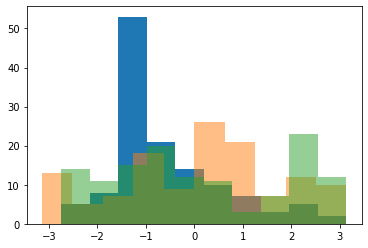

In [24]:
dev_stnd = np.angle(np.exp(1j*(stimpref_dev-stimpref_stnd)))
dev_ctrl = np.angle(np.exp(1j*(stimpref_dev-stimpref)))
ctrl_stnd = np.angle(np.exp(1j*(stimpref-stimpref_stnd)))
plt.hist(dev_stnd)
plt.hist(dev_ctrl,alpha=.5)
plt.hist(ctrl_stnd,alpha=.5)

4


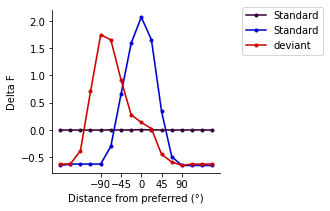

-90.0


In [25]:
incUnits = np.where((np.mean(TC,1)!=0) & (np.max(TCdev,1)<4) & (TC[:,int(len(bins)/2)-1]>TC[:,0]) & (TC[:,int(len(bins)/2)+1]>TC[:,-1]))[0]
print(len(incUnits))

fig,ax = plt.subplots(1,1,figsize=(3,3))
bootstrap = np.zeros((10,len(bins)))
inc = TC[incUnits,:]
n = int(len(inc)/10)
for k in range(10):
    ind = np.delete(np.arange(len(incUnits)),np.arange(k*n,(k+1)*n))
    bootstrap[k,:] = np.median(inc[ind,:],0)
    
plt.fill_between(bins,np.min(bootstrap,0),np.max(bootstrap,0),
        alpha=.2,color=(0.2,0,0.2))

bootstrap = np.zeros((10,len(bins)))
inc = TCdev[incUnits,:]
n = int(len(inc)/10)
for k in range(10):
    ind = np.delete(np.arange(len(incUnits)),np.arange(k*n,(k+1)*n))
    bootstrap[k,:] = np.median(inc[ind,:],0)
plt.fill_between(bins,np.min(bootstrap,0),np.max(bootstrap,0),
        alpha=.2,color=(0.8,0,0))

bootstrap = np.zeros((10,len(bins)))
inc = TCstnd[incUnits,:]
n = int(len(inc)/10)
for k in range(10):
    ind = np.delete(np.arange(len(incUnits)),np.arange(k*n,(k+1)*n))
    bootstrap[k,:] = np.median(inc[ind,:],0)
plt.fill_between(bins,np.min(bootstrap,0),np.max(bootstrap,0),
        alpha=.2,color=(0,0,0.8))

plt.plot(bins,np.median(TC[incUnits,:],0),'.-',color=(0.2,0,0.2),label='Standard')
plt.plot(bins,np.median(TCstnd[incUnits,:],0),'.-',color=(0,0,0.8),label='Standard')
plt.plot(bins,np.median(TCdev[incUnits,:],0),'.-',color=(0.8,0,0),label='deviant')
#plt.xlim(-95,95)
sb.despine()
ax.set_xlabel('Distance from preferred (°)')
ax.set_ylabel('Delta F')
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_xticks(np.arange(-90,91,45))
plt.show()
print(bins[np.argmax(np.median(TCdev[incUnits,:],0))])

In [852]:
stimpref2

array([15, 13,  8,  5,  0,  0,  2, 10,  1, 11,  9,  9,  4, 10, 13, 10,  0,
       14, 12, 15,  7,  0, 10,  5, 13, 10,  0,  9,  8,  5,  1,  0,  0, 11,
        0,  0,  6, 11,  7, 13, 15, 13,  0,  8,  5, 13,  8,  2,  4,  3,  1,
        4,  8,  9,  6,  7,  4, 15,  1,  0, 15,  0,  0,  0, 15, 12, 14,  2,
        8, 10,  1,  8, 10, 13,  9,  2,  4,  1, 11,  0, 12, 11,  0, 11,  8,
       11,  7,  4,  5,  1,  3,  4, 10,  4,  8,  2, 11,  8,  7,  9, 12, 11,
        1, 10,  6, 15,  0, 10,  0,  3, 13,  5, 13,  0,  1,  2,  2,  7, 12,
       14,  2,  6,  9, 13, 10,  1,  0, 10])

In [851]:
stimpref

array([12,  4, 10,  4, 10,  0,  6,  7,  1,  9,  5,  2,  6,  0, 11, 10,  0,
       12, 11,  3,  7, 12, 12, 10,  0, 13,  3,  7,  2,  5, 15,  4,  7,  0,
        3, 15,  9,  4, 10,  2,  0, 10,  3,  3, 14, 10, 12,  7,  7,  2,  7,
       12, 10,  0,  3,  2,  9, 13, 15,  1,  0, 12,  7, 10,  1, 14,  0, 15,
        5, 10, 10,  7,  4,  6,  7,  0,  0,  0, 11, 13, 13,  9,  7,  7, 10,
        0,  4,  3,  7,  2,  7,  6, 12, 10,  4,  3,  2,  7, 10, 13, 10, 12,
       15, 13,  4,  0,  0,  2, 14, 10,  0,  6,  0,  4,  7, 13,  6,  0,  0,
       12,  1,  7, 10, 13,  7,  3, 10, 13])

In [854]:
bins[12]

90.0